# Early Count Analysis

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#File-locations" data-toc-modified-id="File-locations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File locations</a></span></li><li><span><a href="#Plotting-stuff" data-toc-modified-id="Plotting-stuff-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting stuff</a></span></li></ul></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#Recent-polling-data" data-toc-modified-id="Recent-polling-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Recent polling data</a></span></li><li><span><a href="#AEC-Enrolment-data" data-toc-modified-id="AEC-Enrolment-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>AEC Enrolment data</a></span></li><li><span><a href="#Latest-AEC-national-count-data" data-toc-modified-id="Latest-AEC-national-count-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Latest AEC national count data</a></span><ul class="toc-item"><li><span><a href="#First-preference-votes-nationally-by-party" data-toc-modified-id="First-preference-votes-nationally-by-party-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>First preference votes nationally by party</a></span></li><li><span><a href="#First-preference-by-state-by-party" data-toc-modified-id="First-preference-by-state-by-party-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>First preference by state by party</a></span></li><li><span><a href="#Two-party-preferred-votes-by-state" data-toc-modified-id="Two-party-preferred-votes-by-state-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Two party preferred votes by state</a></span></li><li><span><a href="#Two-Party-Preferred-by-Division" data-toc-modified-id="Two-Party-Preferred-by-Division-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Two Party Preferred by Division</a></span></li><li><span><a href="#Two-candidate-preferred-by-Division" data-toc-modified-id="Two-candidate-preferred-by-Division-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Two candidate preferred by Division</a></span></li></ul></li></ul></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#Explore-primary-polls-vs-election-result" data-toc-modified-id="Explore-primary-polls-vs-election-result-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Explore primary polls vs election result</a></span></li><li><span><a href="#Explore-2pp-Polls-vs-Election-Result" data-toc-modified-id="Explore-2pp-Polls-vs-Election-Result-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Explore 2pp Polls vs Election Result</a></span></li><li><span><a href="#State-2pp-swings" data-toc-modified-id="State-2pp-swings-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>State 2pp swings</a></span></li><li><span><a href="#State-primary-first-preference-swings" data-toc-modified-id="State-primary-first-preference-swings-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>State primary first preference swings</a></span></li><li><span><a href="#Divisional-2pp-swings" data-toc-modified-id="Divisional-2pp-swings-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Divisional 2pp swings</a></span></li><li><span><a href="#Green-TCP-swings" data-toc-modified-id="Green-TCP-swings-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Green TCP swings</a></span></li><li><span><a href="#Traditional-TCP-swings" data-toc-modified-id="Traditional-TCP-swings-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Traditional TCP swings</a></span></li><li><span><a href="#Close-seats" data-toc-modified-id="Close-seats-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Close seats</a></span></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python setup

### Imports

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# system imports
from pathlib import Path
import itertools
import numbers

# local imports
import common

### Watermark

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Tue May 24 2022 08:36:32

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

pandas    : 1.4.2
numpy     : 1.22.4
matplotlib: 3.5.2

Watermark: 2.3.0



### File locations

In [3]:
# path to the model data 
PUBLIC_DATA_DIR = '../data/'
Path(PUBLIC_DATA_DIR).mkdir(parents=True, exist_ok=True)

PRIVATE_DATA_DIR = '../historical-data/'
Path(PRIVATE_DATA_DIR).mkdir(parents=True, exist_ok=True)

CHARTS_DIR = '../charts/'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting stuff

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

## Get data

### Recent polling data

In [5]:
FINAL_POLLING_PERIOD = 4 # days - polls in last few days

def get_last_polls():
    current_polls = f'{PUBLIC_DATA_DIR}primary_vote.csv' 
    polls = pd.read_csv(current_polls, parse_dates=['Mean Date'], index_col=0)
    final_date = polls['Mean Date'].max()
    start_date = final_date - pd.Timedelta(days=FINAL_POLLING_PERIOD)
    retain_polls_mask = ((polls['Mean Date'] >= start_date) 
                         & (polls['Mean Date'] <= final_date))
    return polls[retain_polls_mask]

In [6]:
polls = get_last_polls()
PRIMARIES = {
    'Primary vote L/NP': 'Coalition',
    'Primary vote ALP': 'Labor',
    'Primary vote GRN': 'Green',
    'Primary vote ONP': 'One Nation',
    'Primary vote UAP': 'UAP',
    'Primary vote OTH': 'Other',
}
primary_polls = polls.rename(columns=PRIMARIES)
primary_polls_final_mean = (
    # let's do a sample-size weighted average
    (primary_polls[PRIMARIES.values()]
     .mul(primary_polls['Sample size'], axis=0)).sum() 
    / primary_polls['Sample size'].sum()
)
primary_polls_final_mean

Coalition     35.350493
Labor         34.943326
Green         12.438486
One Nation     4.966181
UAP            2.974027
Other          9.327487
dtype: float64

### AEC Enrolment data

In [7]:
enrolmentByDiv = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'GeneralEnrolmentByDivisionDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
enrolmentByDiv.index = enrolmentByDiv['DivisionNm']

enrolment_div = enrolmentByDiv.Enrolment
enrolment_state = enrolmentByDiv.groupby('StateAb').sum().Enrolment

### Latest AEC national count data

#### First preference votes nationally by party

In [8]:
houseFirstPrefsByParty = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseFirstPrefsByPartyDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
houseFirstPrefsByParty = houseFirstPrefsByParty.set_index(['PartyAb'], drop=True)
houseFirstPrefsByParty.columns

Index(['PartyNm', 'OrderOfAppearance', 'Contested', 'Nominations', 'Elected',
       'OrdinaryVotes', 'OrdinaryPercentage', 'AbsentVotes',
       'AbsentPercentage', 'ProvisionalVotes', 'ProvisionalPercentage',
       'PrePollVotes', 'PrePollPercentage', 'PostalVotes', 'PostalPercentage',
       'TotalVotes', 'TotalPercentage', 'TotalSwing'],
      dtype='object')

In [9]:
# Party groupings
groups = {
    'Coalition': ['LP', 'LNP', 'NP', 'CLP'],
    'Labor': ['ALP'],
    'Green': ['GRN'],
    'One Nation': ['ON'],
    'UAP': ['UAPP'],
}
groups['Other'] = (
    list(set(houseFirstPrefsByParty.index.to_list()) 
         - set(itertools.chain.from_iterable(groups.values())))
)

In [10]:
def get_group_totals(data):
    total_votes = data['TotalVotes'].sum()
    primary_tally = {}
    for label, group in groups.items():
        both = list(set(group).intersection(set(data.index)))
        primary_tally[label] = (
            data
            .loc[both, 'TotalVotes']
            .sum() 
            / total_votes * 100
        )
    return pd.Series(primary_tally)

In [11]:
# current state of primary votes
primary_tally = get_group_totals(houseFirstPrefsByParty)
primary_tally

Coalition     35.779739
Labor         32.824887
Green         11.852379
One Nation     4.888070
UAP            4.150913
Other         10.504011
dtype: float64

#### First preference by state by party

In [12]:
houseFirstPrefsByStateByParty2022 = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseFirstPrefsByStateByPartyDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2022 = houseFirstPrefsByStateByParty2022.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2019 = (
    pd.read_csv('https://results.aec.gov.au/24310/Website/'
                'Downloads/HouseFirstPrefsByStateByPartyDownload-24310.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2019 = houseFirstPrefsByStateByParty2019.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2022

,StateAb,PartyNm,OrderOfAppearance,Contested,Nominations,Elected,OrdinaryVotes,OrdinaryPercentage,AbsentVotes,AbsentPercentage,ProvisionalVotes,ProvisionalPercentage,DeclarationPrePollVotes,DeclarationPrePollPercentage,PostalVotes,PostalPercentage,TotalVotes,TotalPercentage,TotalSwing
PartyAb,,,,,,,,,,,,,,,,,,,
LP,NSW,Liberal,1,38,38,0,1059251,27.74,0,0.0,0,0.0,0,0.0,63964,34.41,1123215,28.05,-4.74
NP,NSW,The Nationals,2,9,9,0,339908,8.90,0,0.0,0,0.0,0,0.0,15801,8.50,355709,8.88,-0.88
ALP,NSW,Australian Labor Party,3,47,47,0,1277845,33.47,0,0.0,0,0.0,0,0.0,62052,33.38,1339897,33.46,-1.10
UAPP,NSW,United Australia Party,4,47,47,0,151967,3.98,0,0.0,0,0.0,0,0.0,4530,2.44,156497,3.91,0.53
IND,NSW,Independent,5,27,37,0,295734,7.75,0,0.0,0,0.0,0,0.0,11901,6.40,307635,7.68,3.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDP,NT,Liberal Democratic Party,4,2,2,0,6406,7.29,0,0.0,0,0.0,0,0.0,327,9.08,6733,7.36,7.36
ON,NT,Pauline Hanson's One Nation,5,2,2,0,4504,5.12,0,0.0,0,0.0,0,0.0,219,6.08,4723,5.16,5.16
UAPP,NT,United Australia Party,6,2,2,0,3881,4.41,0,0.0,0,0.0,0,0.0,96,2.67,3977,4.35,1.50


#### Two party preferred votes by state

In [13]:
houseTppByState = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseTppByStateDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)

# State name as index - add percent counted to the data
houseTppByState.index = houseTppByState['StateAb']
houseTppByState['Enrolment'] = enrolment_state
houseTppByState['Counted%'] =  houseTppByState['TotalVotes'] / houseTppByState['Enrolment']* 100.0
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1532306,48.69,1614817,51.31,3147123,-3.09,5472469,57.508284
VIC,VIC,Victoria,1041555,45.20,1262519,54.80,2304074,-1.66,4344208,53.037838
QLD,QLD,Queensland,1008319,54.02,858126,45.98,1866445,-4.42,3503609,53.272069
WA,WA,Western Australia,464259,44.15,587300,55.85,1051559,-11.40,1773969,59.277191
SA,SA,South Australia,306017,43.88,391457,56.12,697474,-5.41,1272047,54.830836
TAS,TAS,Tasmania,114838,48.82,120375,51.18,235213,4.78,402331,58.462559
ACT,ACT,Australian Capital Territory,60157,35.54,109123,64.46,169280,-2.85,314329,53.854401
NT,NT,Northern Territory,40724,44.46,50877,55.54,91601,-1.34,145938,62.767065


In [14]:
labor_tpp_election = (
    houseTppByState['Australian Labor Party Votes'].sum()
    / (houseTppByState['Australian Labor Party Votes'].sum()
       + houseTppByState['Liberal/National Coalition Votes'].sum())
    * 100
)
labor_tpp_election

52.229579110402014

#### Two Party Preferred by Division

In [15]:
houseTppByDivision = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTppByDivisionDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTppByDivision.index = houseTppByDivision['DivisionNm']
houseTppByDivision['Enrolment'] = enrolment_div
houseTppByDivision['Counted%'] =  houseTppByDivision['TotalVotes'] / houseTppByDivision['Enrolment']* 100.0

# IMPORTANT -- How many electorates are missing TPP vote data
houseTppByDivision[(houseTppByDivision['Counted%'] == 0.0)]

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
DivisionNm,,,,,,,,,,,,
Bradfield,Bradfield,108,NSW,NaN,0,0.0,0,0.0,0,-66.56,108573,0.0
Brisbane,Brisbane,156,QLD,NaN,0,0.0,0,0.0,0,-54.92,125241,0.0
Calare,Calare,109,NSW,NaN,0,0.0,0,0.0,0,-63.29,121564,0.0
Canberra,Canberra,101,ACT,NaN,0,0.0,0,0.0,0,-32.92,102196,0.0
Clark,Clark,319,TAS,NaN,0,0.0,0,0.0,0,-33.83,74797,0.0
Cooper,Cooper,320,VIC,NaN,0,0.0,0,0.0,0,-23.79,108730,0.0
Cowper,Cowper,113,NSW,NaN,0,0.0,0,0.0,0,-61.88,129887,0.0
Curtin,Curtin,238,WA,NaN,0,0.0,0,0.0,0,-63.95,119397,0.0
Fowler,Fowler,119,NSW,NaN,0,0.0,0,0.0,0,-36.01,108517,0.0


In [16]:
# make a more useful index
houseTppByDivision.index = (
    houseTppByDivision['DivisionNm'] + ' (' + 
    houseTppByDivision['StateAb'] + ')'
)
houseTppByDivision.head()

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,32181,37.76,53038,62.24,85219,-4.06,130151,65.477023
Aston (VIC),Aston,197,VIC,NaN,40653,52.86,36249,47.14,76902,-7.27,109826,70.021671
Ballarat (VIC),Ballarat,198,VIC,NaN,28907,36.96,49303,63.04,78210,-2.81,110704,70.647854
Banks (NSW),Banks,103,NSW,NaN,44149,53.67,38109,46.33,82258,-2.59,107786,76.316034
Barker (SA),Barker,180,SA,NaN,57970,65.15,31012,34.85,88982,-3.79,123518,72.039703


#### Two candidate preferred by Division

In [17]:
houseTcp = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTcpByCandidateByVoteTypeDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTcp.head()

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
0,ACT,318,Bean,36231,SMITH,David,3,N,Y,ALP,Australian Labor Party,53561,0,0,0,2339,55900,5.64
1,ACT,318,Bean,37198,HIATT,Jane,6,N,N,LP,Liberal,31051,0,0,0,1554,32605,-5.64
2,ACT,101,Canberra,36241,HOLLO,Tim,5,N,N,GRN,The Greens,14346,0,0,0,615,14961,37.17
3,ACT,101,Canberra,36228,PAYNE,Alicia,6,N,Y,ALP,Australian Labor Party,23962,0,0,0,1330,25292,62.83
4,ACT,102,Fenner,36234,LEIGH,Andrew,1,N,Y,ALP,Australian Labor Party,50900,0,0,0,2323,53223,5.33


In [18]:
COALITION = ['LNP', 'LP', 'NP', 'CLP']
tcp_swings = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='Swing', columns='PartyAb')

# check we do not have any Coalition v Coalition contests
assert (tcp_swings[COALITION].notna().sum(axis=1) <= 1).any()

In [19]:
tcp_swings['Coalition'] = (
    tcp_swings[COALITION].sum(axis=1)
    .where(tcp_swings[COALITION].notna().any(axis=1), other=np.nan)
)
tcp_swings = tcp_swings.drop(columns=COALITION)
tcp_swings.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,4.06,NaN,NaN,NaN,NaN,-4.06
Aston,7.27,NaN,NaN,NaN,NaN,-7.27
Ballarat,2.81,NaN,NaN,NaN,NaN,-2.81
Banks,2.59,NaN,NaN,NaN,NaN,-2.59
Barker,3.79,NaN,NaN,NaN,NaN,-3.79


In [20]:
raw_tcp_votes = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='TotalVotes', columns='PartyAb')

# Check for Coalition v Coalition contests
assert (raw_tcp_votes[COALITION].notna().sum(axis=1) <= 1).any()

raw_tcp_votes['Coalition'] = (
    raw_tcp_votes[COALITION].sum(axis=1)
    .where(raw_tcp_votes[COALITION].notna().any(axis=1), other=np.nan)
)
raw_tcp_votes = raw_tcp_votes.drop(columns=COALITION)
raw_tcp_counted = raw_tcp_votes.sum(axis=1) / enrolment_div * 100 
raw_tcp_counted.head()

DivisionNm
Adelaide    65.477023
Aston       70.021671
Ballarat    70.647854
Banks       76.316034
Barker      72.039703
dtype: float64

In [21]:
pct_tcp_votes = raw_tcp_votes.div(raw_tcp_votes.sum(axis=1), axis=0)
pct_tcp_votes.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,0.622373,NaN,NaN,NaN,NaN,0.377627
Aston,0.471366,NaN,NaN,NaN,NaN,0.528634
Ballarat,0.630393,NaN,NaN,NaN,NaN,0.369607
Banks,0.463286,NaN,NaN,NaN,NaN,0.536714
Barker,0.348520,NaN,NaN,NaN,NaN,0.651480


## Plots

### Explore primary polls vs election result

In [22]:
colours = {
    'Coalition': 'blue',
    'Labor': '#dd0000',
    'Green': 'green',
    'One Nation': 'darkorange',
    'UAP': 'gold',
    'Other': 'darkorchid',
}


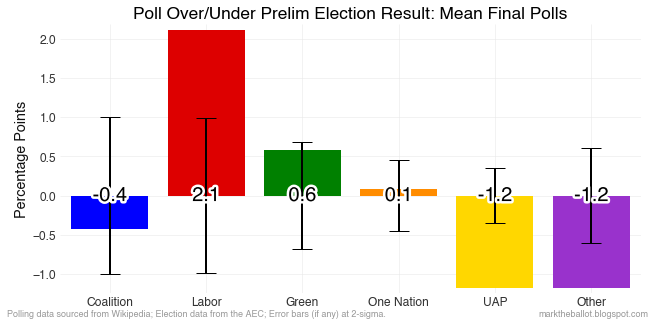

In [23]:
def difference_plot(polls, election, sample_size=None, **kwargs):
    
    SIGMA = 2
    compar = polls - election
    colors = kwargs['colors'] if 'colors' in kwargs else 'darkcyan'
    if type(colors) is str:
        colors = pd.Series([colors]*len(compar), index=compar.index)

    fig, ax = common.initiate_plot()
    for x, y in compar.iteritems():
        ax.bar(x, y, color=colors[x])
        text = ax.text(x, 0, f'{y:0.1f}', ha='center', va='center',
            fontsize=20)
        text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])
        
        if sample_size is not None:
            ss = sample_size if isinstance(sample_size, numbers.Number) else sample_size[x]
            p = polls[x] / 100
            z = np.sqrt((p*(1-p))/ss) * 100
            ax.errorbar(x, 0, yerr=SIGMA*z, ecolor='black', capsize=10)
        
    title = kwargs['title'] if 'title' in kwargs else None
    common.plot_finalise(
        ax, 
        title=title, 
        ylabel='Percentage Points', 
        lfooter='Polling data sourced from Wikipedia; '
                'Election data from the AEC; '
                f'Error bars (if any) at {SIGMA}-sigma.', 
    )

difference_plot(primary_polls_final_mean, primary_tally, 
                primary_polls['Sample size'].sum(), 
                colors=colours,
                title='Poll Over/Under Prelim Election Result: Mean Final Polls')

In [24]:
primary_polls.columns

Index(['Coalition', 'Labor', 'Green', 'One Nation', 'UAP', 'Other', 'Date',
       'Mean Date', 'Brand', 'Interview mode', 'Sample size',
       'Calculated 2pp L/NP', 'Calculated 2pp ALP'],
      dtype='object')

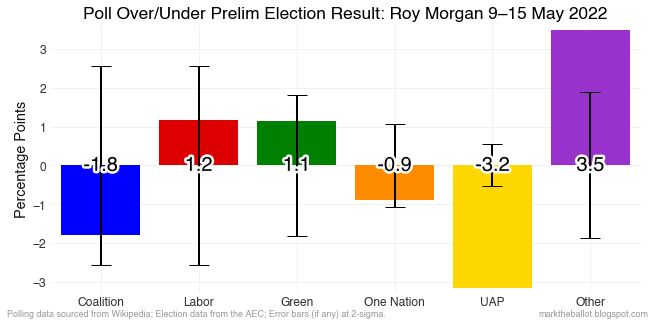

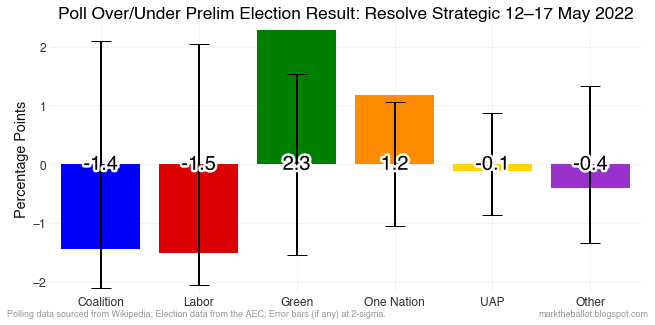

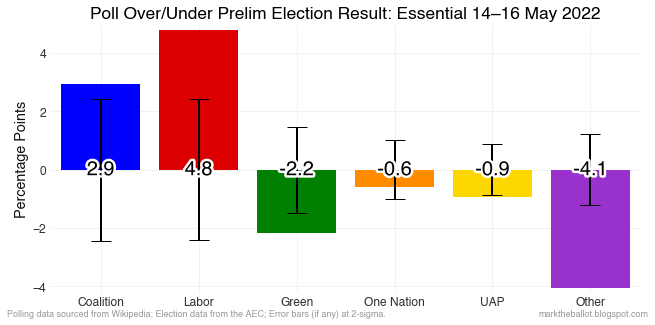

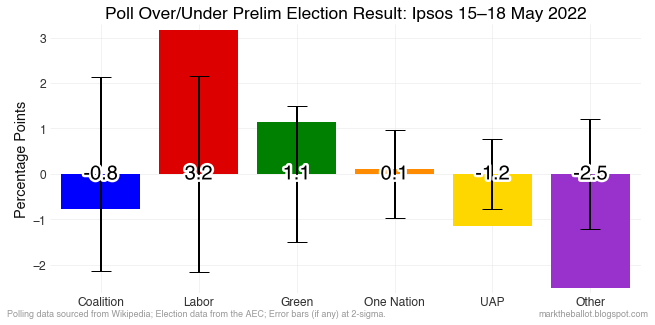

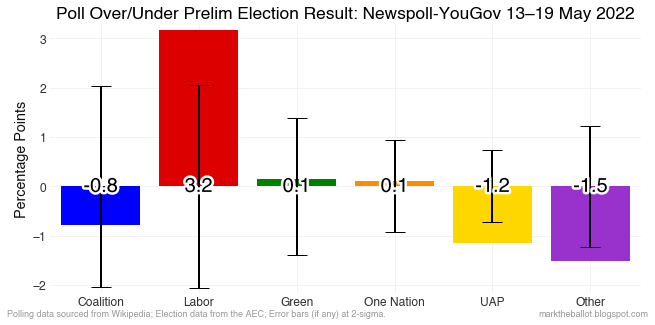

In [25]:
primary_polls.index = primary_polls['Brand'] + ' ' + primary_polls['Date']
for name, poll in primary_polls.iterrows():
    title = f'Poll Over/Under Prelim Election Result: {name}'
    sample_size = poll['Sample size']
    difference_plot(poll[PRIMARIES.values()], primary_tally, 
                    sample_size=sample_size, 
                    colors=colours,
                    title=title)

### Explore 2pp Polls vs Election Result

In [26]:
MFP = 'Mean final polls'
tpp = primary_polls.copy()
tpp.index =  tpp['Brand'] + '\n' +  tpp['Date']
addition = pd.Series([np.nan]*len(tpp.columns), index=tpp.columns, name=MFP)
addition['Sample size'] = tpp['Sample size'].sum()
addition['Calculated 2pp ALP'] = (
    # let's do a weitherd mean
    (tpp['Calculated 2pp ALP'] * tpp['Sample size']).sum()
    / tpp['Sample size'].sum()
)
addition = pd.DataFrame(addition).T
tpp = pd.concat([tpp, addition])

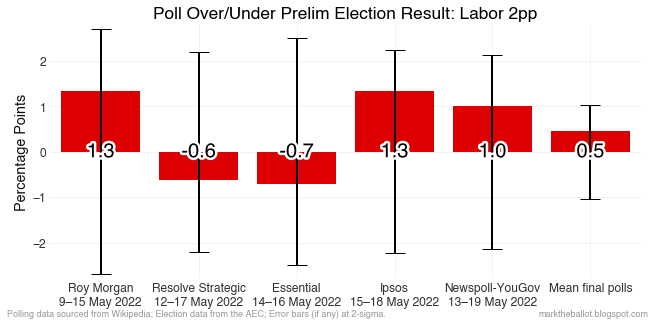

In [27]:
title = 'Poll Over/Under Prelim Election Result: Labor 2pp'
sample_size = poll['Sample size']
difference_plot(tpp['Calculated 2pp ALP'], labor_tpp_election, 
                    sample_size=tpp['Sample size'], 
                    colors='#dd0000',
                    title=title)


### State 2pp swings

In [28]:
def set_up_swing_chart(data:pd.Series):
    
    assert isinstance(data, pd.Series)
    fig, ax = common.initiate_plot()
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)

    rightax = ax.twinx()
    ax.get_shared_y_axes().join(ax, rightax)
    rightax.grid(False)
    
    sorted_data = data.sort_values()
    labels = sorted_data.index
    sorted_data = sorted_data.reset_index(drop=True)
    
    ylims = sorted_data.index.min() - 0.5, sorted_data.index.max() + 0.5
    ax.set_ylim(ylims)
    rightax.set_ylim(ylims)
   
    return ax, rightax, sorted_data, labels


def finalise_swing_chart(ax, rightax, data, labels):

    ax.yaxis.set_ticks_position('left')
    rightax.yaxis.set_ticks_position('right')
    ax.spines['left'].set_position(('data',0),)
    ax.spines['left'].set_color('#999999')
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(1)
    rightax.spines['right'].set_position(('data',0))

    ax.set_yticks(data.index)
    rightax.set_yticks(data.index)

    ax.set_yticklabels(labels.where(data >= 0, other=''))
    rightax.set_yticklabels(labels.where(data < 0, other=''))


In [29]:
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1532306,48.69,1614817,51.31,3147123,-3.09,5472469,57.508284
VIC,VIC,Victoria,1041555,45.20,1262519,54.80,2304074,-1.66,4344208,53.037838
QLD,QLD,Queensland,1008319,54.02,858126,45.98,1866445,-4.42,3503609,53.272069
WA,WA,Western Australia,464259,44.15,587300,55.85,1051559,-11.40,1773969,59.277191
SA,SA,South Australia,306017,43.88,391457,56.12,697474,-5.41,1272047,54.830836
TAS,TAS,Tasmania,114838,48.82,120375,51.18,235213,4.78,402331,58.462559
ACT,ACT,Australian Capital Territory,60157,35.54,109123,64.46,169280,-2.85,314329,53.854401
NT,NT,Northern Territory,40724,44.46,50877,55.54,91601,-1.34,145938,62.767065


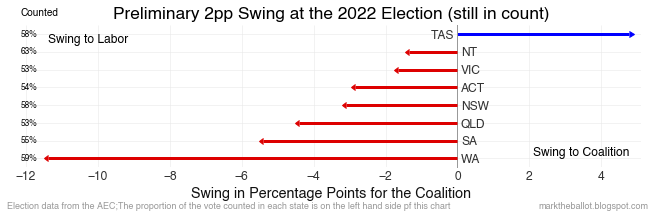

In [30]:
# marshall our data
data = houseTppByState['Swing']

# plot our data
ax, rightax, data, labels = set_up_swing_chart(houseTppByState['Swing'])
ax.figure.set_size_inches(9, 3)
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each state
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByState.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

# annotate axes
ax.text(data.min(), data.index.max(), 'Swing to Labor',
        ha='left', va='top', fontsize='large')
ax.text(data.max(), data.index.min(), 'Swing to Coalition',
        ha='right', va='bottom', fontsize='large')

common.plot_finalise(
    ax, 
    title='Preliminary 2pp Swing at the 2022 Election (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points for the Coalition', 
    lfooter='Election data from the AEC;'
            'The proportion of the vote counted in each state is on the left hand side pf this chart', 
)

### State primary first preference swings

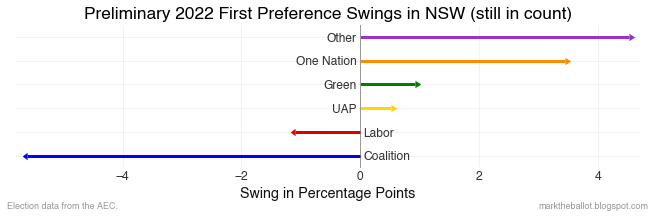

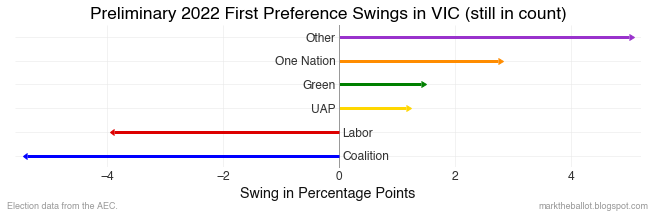

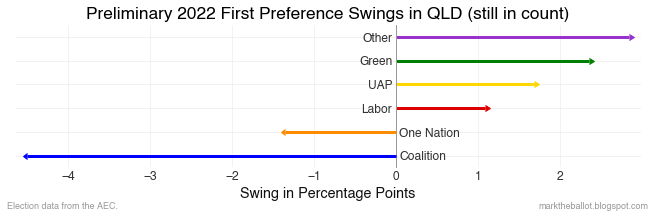

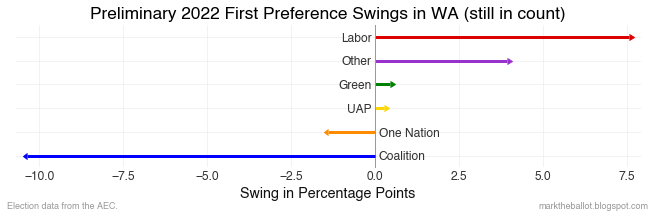

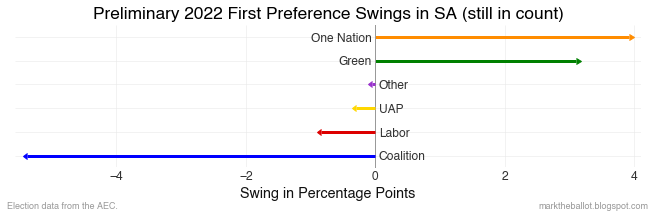

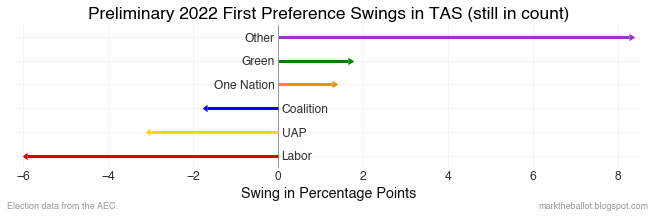

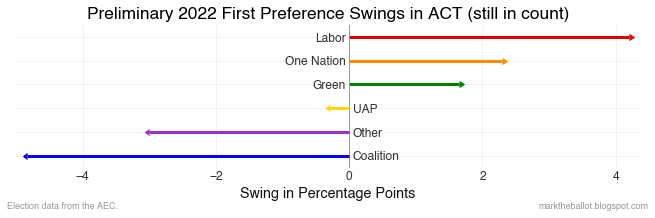

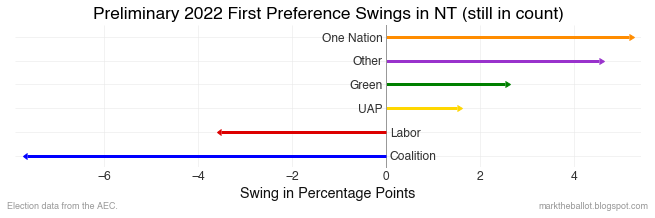

In [31]:
d22 = houseFirstPrefsByStateByParty2022
d19 = houseFirstPrefsByStateByParty2019

combined = {}
for state in d22['StateAb'].unique():

    # data marshalling 
    state2022 = d22[d22['StateAb'] == state].copy()
    state2019 = d19[d19['StateAb'] == state].copy()
    grouped2022 = get_group_totals(state2022)
    grouped2019 = get_group_totals(state2019)
    swings2022 = (grouped2022 - grouped2019).sort_values()
    for group, value in swings2022.iteritems():
        if group in combined:
            combined[group] = combined[group] | {state: value} # Python 3.10 feature
        else:
            combined[group] = {state: value}
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(swings2022)
    ax.figure.set_size_inches(9, 3)


    for x, y, l in zip(data, data.index, labels):
        ecolor = colours[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)

    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings in {state} (still in count)',
        ylabel=None,
        xlabel='Swing in Percentage Points', 
        lfooter='Election data from the AEC.', 
    )    

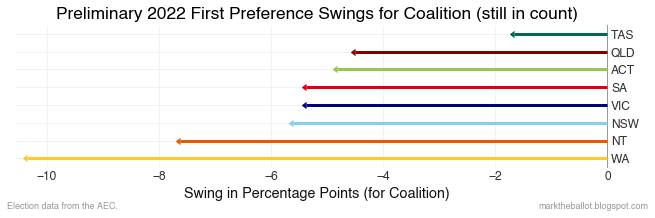

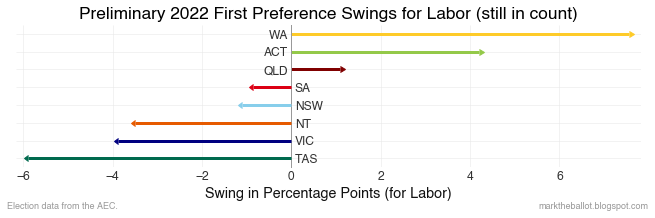

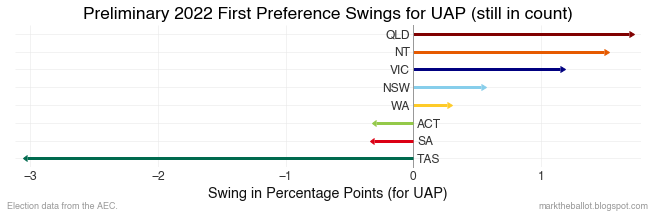

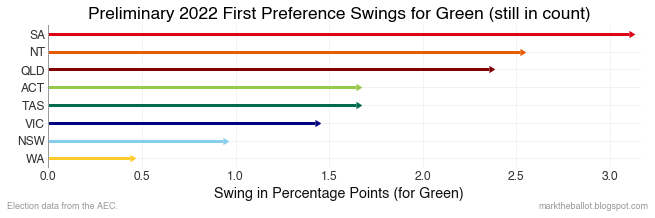

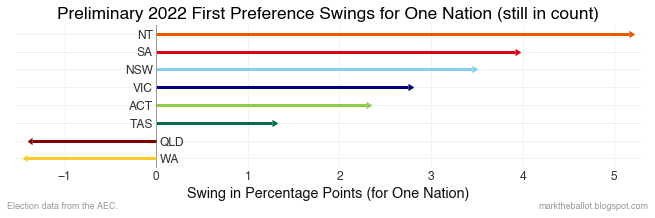

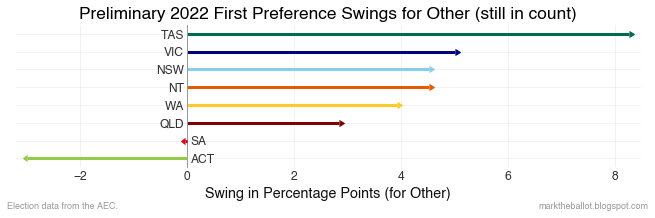

In [32]:
state_palette = {
    # colours from the R strayr package
    "NSW": '#87ceeb',
    "VIC": '#000080', 
    "QLD": '#800000', 
    "WA": '#fecb29', 
    "SA": '#dc0014', 
    "TAS": '#006a4e', 
    "ACT": '#94c949', 
    "NT": '#e65a00',
}

for group, dict_ in combined.items():
    
    # data
    series = pd.Series(dict_)
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(series)
    ax.figure.set_size_inches(9, 3)
    
    for x, y, l in zip(data, data.index, labels):
        ecolor = state_palette[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)
    
    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings for {group} (still in count)',
        ylabel=None,
        xlabel=f'Swing in Percentage Points (for {group})', 
        lfooter='Election data from the AEC.', 
    )        


### Divisional 2pp swings

In [33]:
houseTppByDivision

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,32181,37.76,53038,62.24,85219,-4.06,130151,65.477023
Aston (VIC),Aston,197,VIC,NaN,40653,52.86,36249,47.14,76902,-7.27,109826,70.021671
Ballarat (VIC),Ballarat,198,VIC,NaN,28907,36.96,49303,63.04,78210,-2.81,110704,70.647854
Banks (NSW),Banks,103,NSW,NaN,44149,53.67,38109,46.33,82258,-2.59,107786,76.316034
Barker (SA),Barker,180,SA,NaN,57970,65.15,31012,34.85,88982,-3.79,123518,72.039703
...,...,...,...,...,...,...,...,...,...,...,...,...
Werriwa (NSW),Werriwa,153,NSW,NaN,35943,44.81,44269,55.19,80212,0.28,126141,63.589158
Whitlam (NSW),Whitlam,150,NSW,NaN,39410,40.12,58824,59.88,98234,1.03,125535,78.252280
Wide Bay (QLD),Wide Bay,178,QLD,NaN,49845,61.53,31162,38.47,81007,-1.62,115420,70.184543
Wills (VIC),Wills,234,VIC,NaN,0,0.00,0,0.00,0,-24.29,108500,0.000000


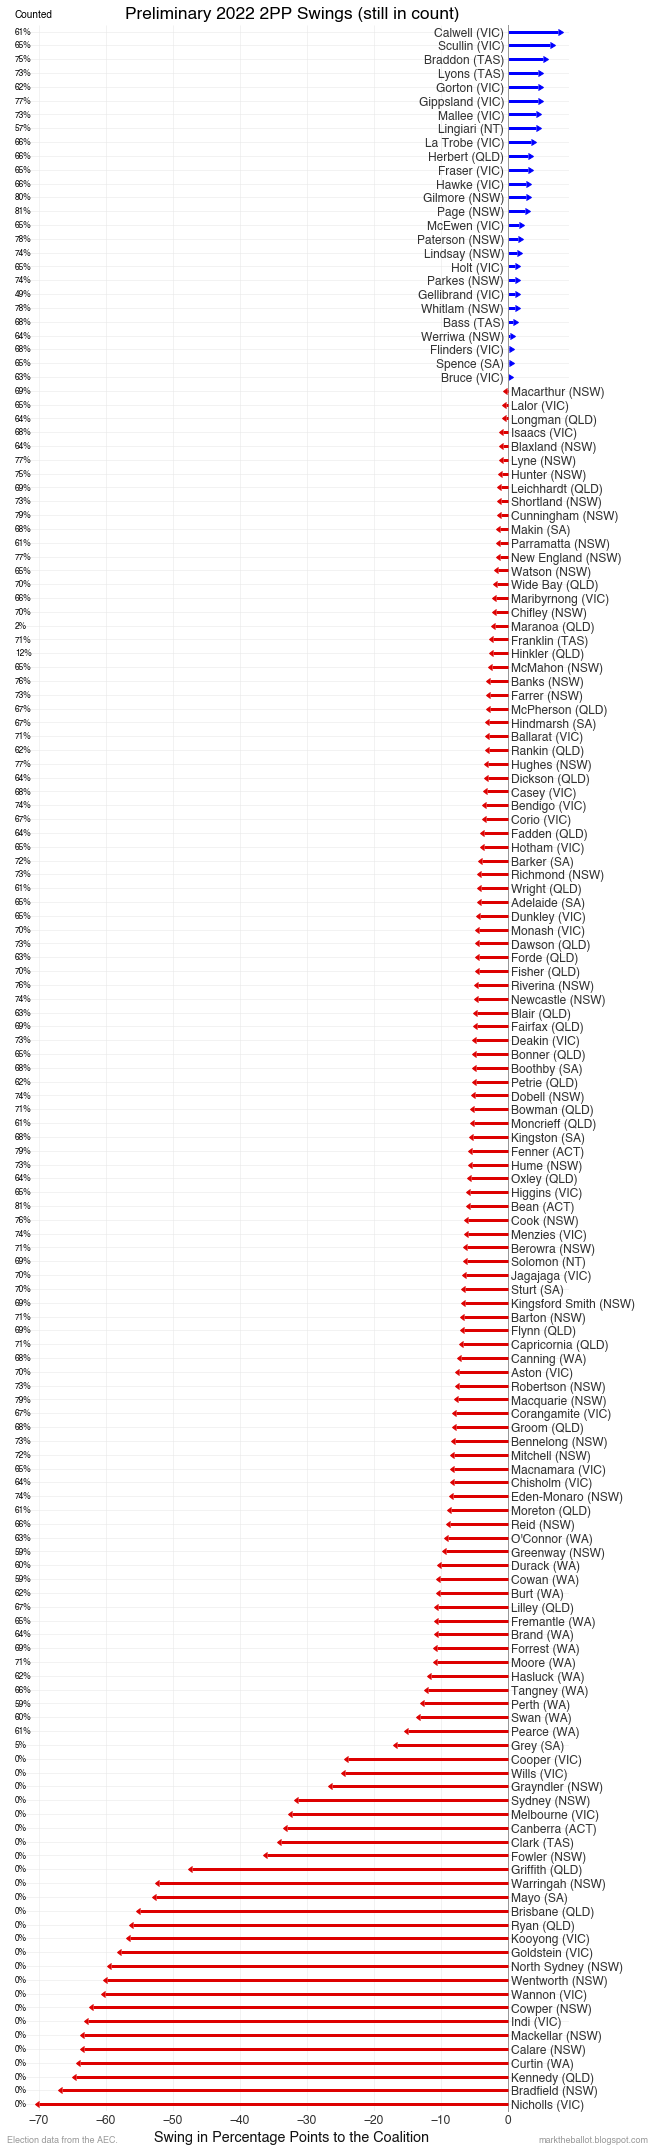

In [34]:
data = houseTppByDivision['Swing'].copy()
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9, 30)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')

finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByDivision.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Preliminary 2022 2PP Swings (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter='Election data from the AEC. ', 
)    

### Green TCP swings

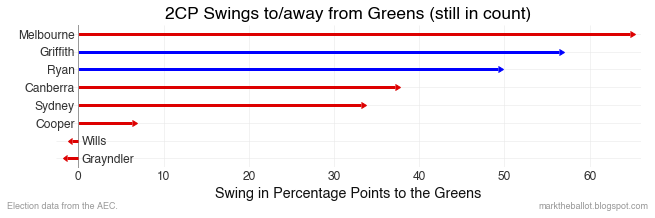

In [35]:
x_colors = {
    'ALP': '#dd0000',
    'Coalition': 'blue',
    'GRN': 'green',
    'IND': 'darkorange'
}

GREEN = 'GRN'
orig_ = tcp_swings[tcp_swings[GREEN].notna()]
greens = orig_[GREEN]

ax, rightax, series, labels = set_up_swing_chart(greens)
ax.figure.set_size_inches(9, 3)

# plot our data
for x, y, label in zip(series, series.index, labels):
    kommen = orig_.drop(GREEN, axis=1).loc[label].idxmax()
    c = x_colors[kommen]
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=c)
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=c)
        
finalise_swing_chart(ax, rightax, series, labels)

common.plot_finalise(
    ax, 
    title=f'2CP Swings to/away from Greens (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Greens', 
    lfooter='Election data from the AEC.', 
) 

### Traditional TCP swings

In [36]:
missing = tcp_swings.isna().all(axis=1)
missing_text = f'Missing from AEC feed: {(", ").join(missing[missing].index)}.' if missing.any() else ''
missing_text

''

In [37]:
TRADITIONAL = ['ALP', 'Coalition']
data = tcp_swings[tcp_swings[TRADITIONAL].notna().all(axis=1)]
data = data['Coalition']
data

DivisionNm
Adelaide   -4.06
Aston      -7.27
Ballarat   -2.81
Banks      -2.59
Barker     -3.79
            ... 
Watson     -1.47
Werriwa     0.28
Whitlam     1.03
Wide Bay   -1.62
Wright     -4.00
Name: Coalition, Length: 127, dtype: float64

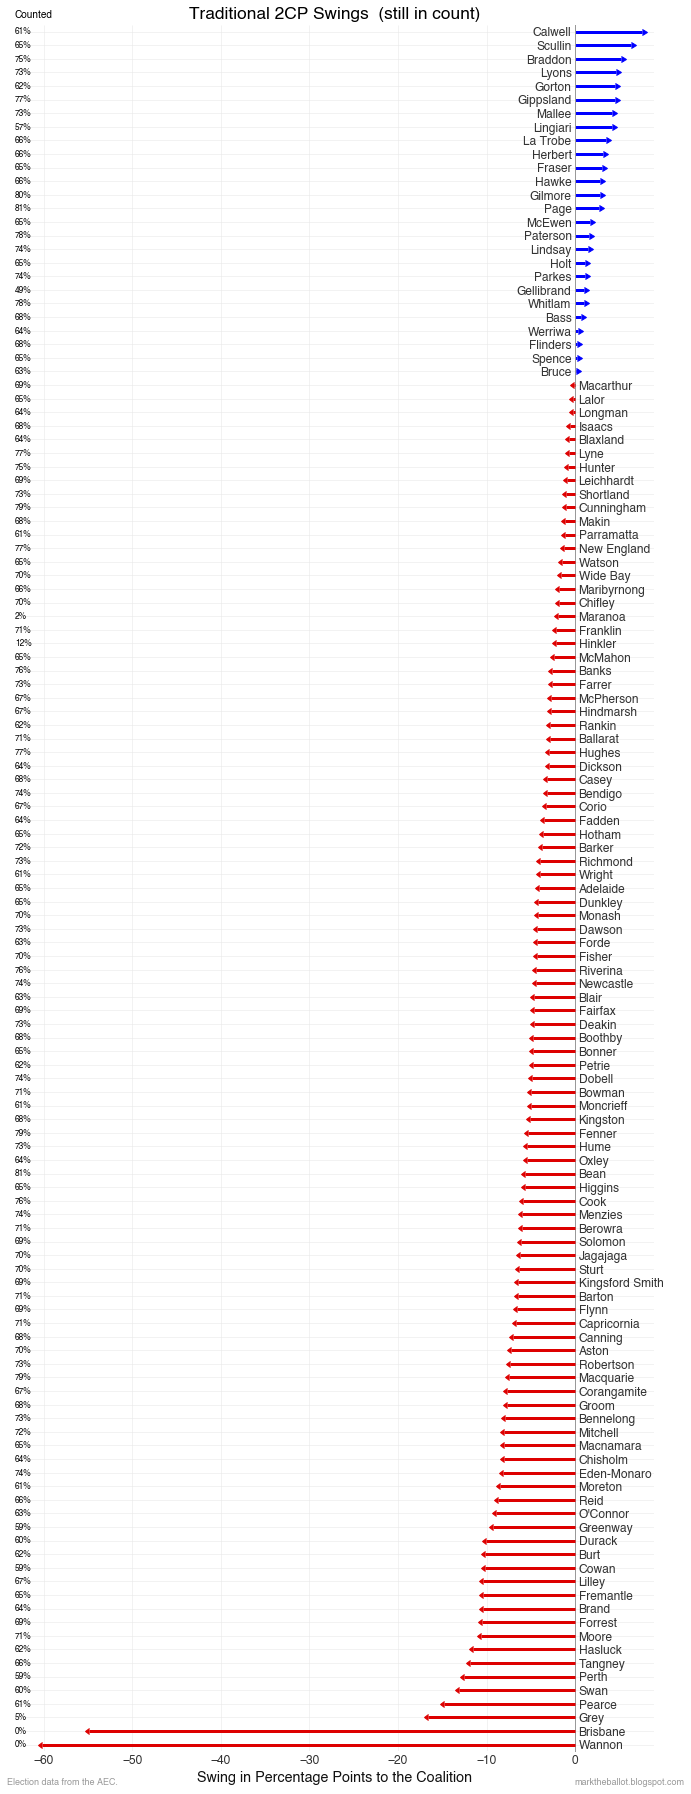

In [38]:
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9.5, 25)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{raw_tcp_counted[label]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Traditional 2CP Swings  (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter=f'Election data from the AEC. {missing_text}', 
)    

In [39]:
tcp_swings.loc['Brisbane']

PartyAb
ALP         -45.08
GRN            NaN
IND            NaN
KAP            NaN
XEN            NaN
Coalition   -54.92
Name: Brisbane, dtype: float64

### Close seats

In [40]:
missing = pct_tcp_votes.isna().all(axis=1)
missing_text = f'Missing from AEC 2CP feed: {(", ").join(missing[missing].index)}. ' if missing.any() else ''
missing_text

'Missing from AEC 2CP feed: Brisbane, Wannon. '

In [41]:
THRESH = 0.525
close = pct_tcp_votes.max(axis=1) <= THRESH
close_tcp_votes = pct_tcp_votes[close]
max_value = close_tcp_votes.max(axis=1)
max_label = close_tcp_votes.idxmax(axis=1)
min_label = close_tcp_votes.idxmin(axis=1)
data = (
    pd.DataFrame({'Values': max_value.values * 100, 
                  'Group': max_label.values, 
                  'Seat': close_tcp_votes.index },
                 index=[f'{seat} {a}-vs-{b}' 
                       for seat, a, b in zip(close_tcp_votes.index, max_label, min_label)],)
).sort_values('Values')
data

,Values,Group,Seat
Deakin Coalition-vs-ALP,50.033299,Coalition,Deakin
Gilmore Coalition-vs-ALP,50.150183,Coalition,Gilmore
Sturt Coalition-vs-ALP,50.543719,Coalition,Sturt
Lyons ALP-vs-Coalition,50.578281,ALP,Lyons
Ryan Coalition-vs-GRN,50.711744,Coalition,Ryan
Bennelong ALP-vs-Coalition,50.963906,ALP,Bennelong
Menzies Coalition-vs-ALP,51.040352,Coalition,Menzies
Moore Coalition-vs-ALP,51.041581,Coalition,Moore
Bass Coalition-vs-ALP,51.132145,Coalition,Bass
Lingiari ALP-vs-Coalition,51.270415,ALP,Lingiari


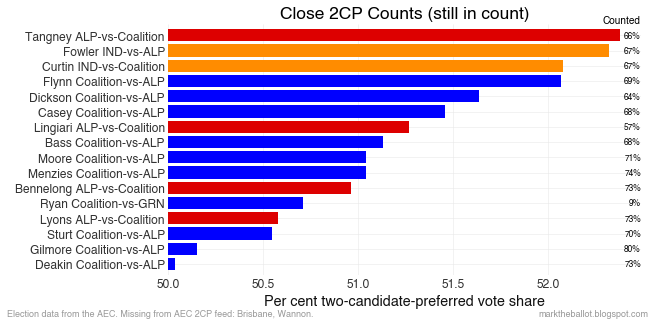

In [42]:
# plot our data
fig, ax = common.initiate_plot()
for x, y, c in zip(data['Values'], data.index, data['Group']):
    color = x_colors[c]
    ax.barh(y, x-50, left=50, color=color)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo, xlim_high+adj)
for y, label in enumerate(data['Seat']):
    text = f'{raw_tcp_counted[label]:0.0f}%'
    ax.text(xlim_high+adj, y, text, ha='right', va='center', fontsize='small')
ax.text(xlim_high+adj, y+1, 'Counted', ha='right', va='center', )

    
common.plot_finalise(
    ax, 
    title=f'Close 2CP Counts (still in count)',
    ylabel=None,
    xlabel='Per cent two-candidate-preferred vote share', 
    lfooter=f'Election data from the AEC. {missing_text}', 
)    

In [43]:
tcp_votes.loc['Richmond']

NameError: name 'tcp_votes' is not defined

## The End

In [ ]:
print('Done')